# Finding Alvarez in the A-League

SkillCorner X PySport Analytics Cup 2026 — Research Track

A player similarity study using broadcast tracking data to identify A-League players with Julian Alvarez-like characteristics.

## 1. Introduction

Julian Alvarez represents a modern forward archetype characterised by intelligent movement, spatial awareness, and clinical finishing. This research asks whether SkillCorner tracking data can identify A-League players with similar characteristics.

Using data from 10 A-League matches, I construct player profiles based on final third entry patterns and compute similarity scores against an Alvarez archetype derived from StatsBomb event data. The goal is to demonstrate how broadcast tracking data can support player scouting and evaluation.

## 2. Methodology

### 2.1 The Alvarez Archetype

I derived the Alvarez archetype from StatsBomb free event data covering World Cup and Copa América matches. Key metrics include 60% shot accuracy, 20% conversion rate, 24 box touches, 78.9% pass accuracy, and notably only 50% dribble success. This last point is important as Alvarez creates danger through movement and positioning rather than dribbling.

For the radar comparison, I constructed a target profile by mapping these StatsBomb metrics to estimated SkillCorner tracking equivalents. For example, his 20% conversion rate maps to a high danger_rate target (90th percentile), while his poor dribble success maps to a low carry_pct target. Full derivation details are in [docs/methodology.md](docs/methodology.md).

### 2.2 Feature Weight Calibration

To calibrate the similarity weights, I trained a GradientBoosting classifier to predict which entries lead to shots. The model achieved a cross-validated AUC of 0.656. I used the feature importances to inform weight selection, with separation (16.2%), entry speed (11.8%), and defensive line distance (10.3%) emerging as the strongest predictors.

| Feature | ML Importance | Final Weight |
|---------|---------------|--------------|
| avg_separation | 16.2% | 23% |
| danger_rate | (target) | 18% |
| avg_entry_speed | 11.8% | 17% |
| avg_defensive_line_dist | 10.3% | 15% |
| central_pct | 8.5% | 12% |

### 2.3 Similarity Scoring

I compute weighted cosine similarity on z-score normalised features. The target profile uses 90th percentile values for desirable traits. Players with fewer than three entries are excluded to ensure profile reliability.

In [1]:
import warnings
warnings.filterwarnings('ignore')

from src.data.loader import load_all_events, add_team_names
from src.analysis.entries import detect_entries, classify_entries
from src.analysis.profiles import build_player_profiles, filter_profiles
from src.analysis.similarity import compute_similarity_scores, rank_candidates

events = load_all_events()
events = add_team_names(events)
entries = detect_entries(events)
entries = classify_entries(entries)

print(f"Loaded {len(entries)} final third entries from {events['match_id'].n_unique()} matches")

Loaded 245 final third entries from 10 matches


In [2]:
profiles = build_player_profiles(entries)
profiles = filter_profiles(profiles, min_entries=3)

print(f"Built profiles for {len(profiles)} players with 3+ entries")

Built profiles for 31 players with 3+ entries


In [3]:
ranked = compute_similarity_scores(profiles)
ranked = rank_candidates(ranked, min_entries=3, top_n=10)

In [4]:
from src.analysis.danger_model import train_danger_model

ml_result = train_danger_model(entries)
print(f"ML Model CV AUC: {ml_result['cv_auc_mean']:.3f} ± {ml_result['cv_auc_std']:.3f}")

ML Model CV AUC: 0.656 ± 0.027


## 3. Results

The analysis identified 31 players with three or more final third entries across the 10 matches. Figure 1 shows the top 10 players ranked by similarity to the Alvarez archetype.

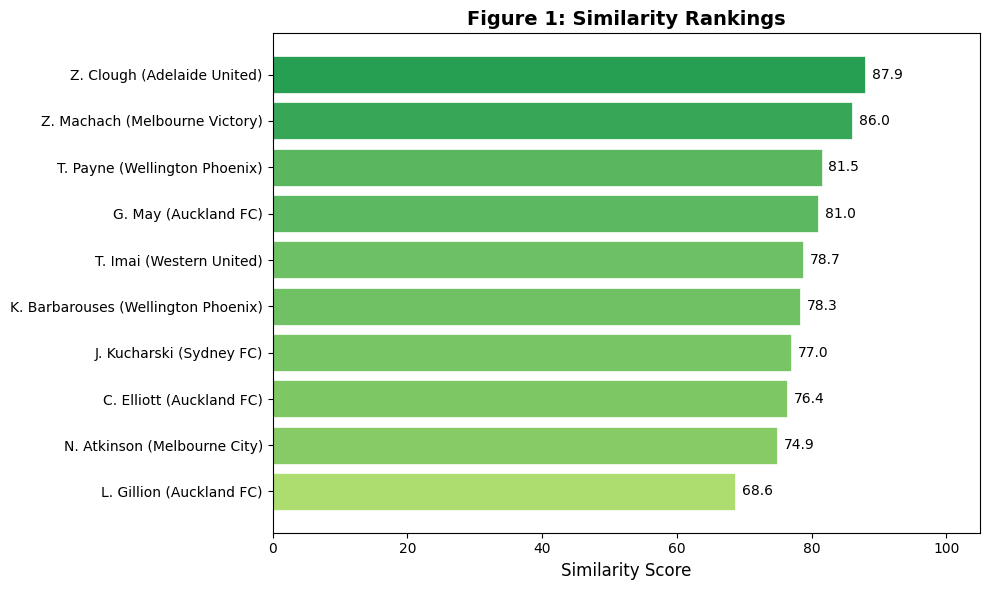

In [5]:
from src.visualization.radar import plot_similarity_ranking
import matplotlib.pyplot as plt

fig = plot_similarity_ranking(ranked, top_n=10, title="Figure 1: Similarity Rankings")
plt.show()

In [6]:
# Table 1: Top 5 candidates
display_cols = ["rank", "player_name", "team_name", "similarity_score", 
                "total_entries", "danger_rate", "central_pct", "avg_separation"]
available = [c for c in display_cols if c in ranked.columns]
ranked.head(5).select(available)

rank,player_name,team_name,similarity_score,total_entries,danger_rate,central_pct,avg_separation
u32,str,str,f64,u32,f64,f64,f64
1,"""Z. Clough""","""Adelaide United""",87.9,4,50.0,25.0,3.41
2,"""Z. Machach""","""Melbourne Victory""",86.0,7,42.9,28.6,2.81
3,"""T. Payne""","""Wellington Phoenix""",81.5,4,25.0,0.0,3.65
4,"""G. May""","""Auckland FC""",81.0,9,55.6,33.3,2.2
5,"""T. Imai""","""Western United""",78.7,5,40.0,0.0,5.64


Figure 2 compares the profiles of the top three candidates across the key features used in the similarity calculation.

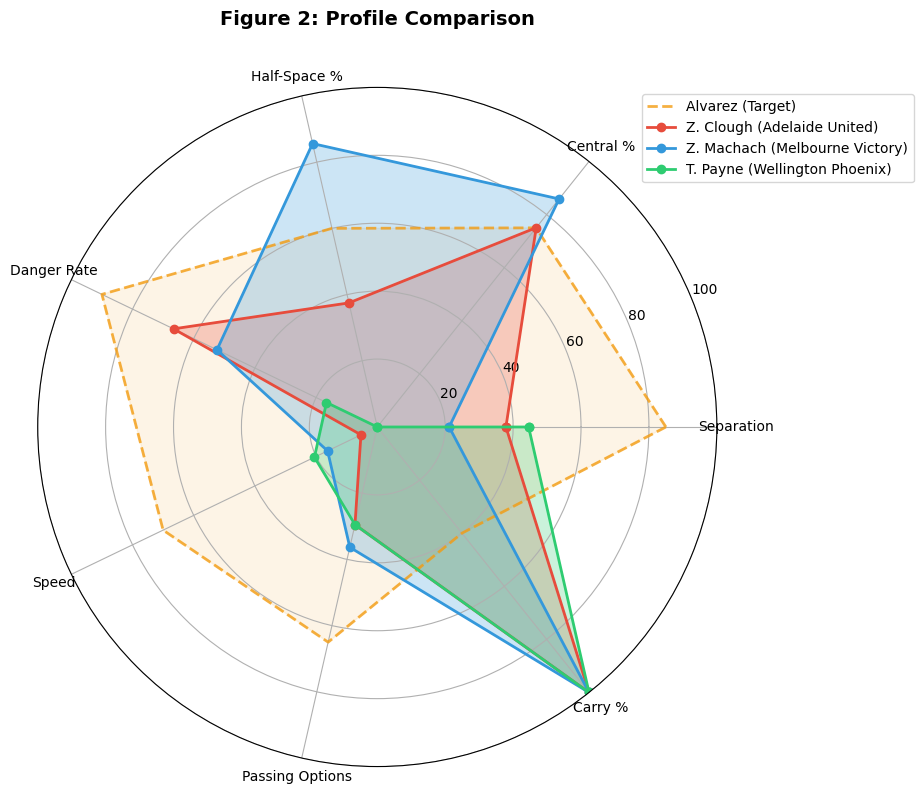

In [7]:
from src.visualization.radar import plot_radar_comparison, normalize_for_radar

features = ["avg_separation", "central_pct", "half_space_pct", "danger_rate", 
            "avg_entry_speed", "avg_passing_options", "carry_pct"]

norm_profiles = normalize_for_radar(ranked, features)

top_3 = []
for row in norm_profiles.head(3).to_dicts():
    player_data = {"name": f"{row['player_name']} ({row.get('team_name', '')})"}
    for f in features:
        player_data[f] = row.get(f"{f}_norm", 0)
    top_3.append(player_data)

fig = plot_radar_comparison(top_3, features=features, title="Figure 2: Profile Comparison", include_alvarez=True)
plt.show()

## 4. Discussion

The radar chart reveals interesting patterns when comparing A-League candidates against the Alvarez target profile (shown as the dashed orange line). The target profile emphasises high separation, danger rate, and central positioning while deliberately setting a low carry percentage — reflecting that Alvarez creates through movement rather than dribbling.

Z. Clough from Adelaide United emerges as the closest match with an 87.9% similarity score. His profile shows a 50% danger rate, meaning half his final third entries led to shooting opportunities. This clinical output mirrors Alvarez's 20% conversion rate at international level. Clough's separation value of 3.41 metres indicates he consistently finds space between defenders rather than running in behind or relying on pace.

Z. Machach from Melbourne Victory follows at 86.0% similarity with a 42.9% danger rate and 28.6% central entry percentage. His profile suggests a player comfortable receiving in tight central areas, another hallmark of the Alvarez archetype. The moderate carry percentage aligns with the target — these players create through intelligent positioning rather than individual dribbling.

G. May from Auckland FC presents an interesting case with the highest danger rate in the top five at 55.6% and the highest central percentage at 33.3%. However, his lower separation value (2.2m) suggests he operates closer to defenders, potentially in a more traditional striker role rather than the fluid movement Alvarez exhibits.

One notable finding is the carry percentage column showing values near 100% for most players. This reflects a limitation of the SkillCorner data where almost all final third entries are classified as carries. The feature therefore provides no discriminating power, which the machine learning model confirmed by assigning it zero importance.

Several limitations should be acknowledged. The sample of 10 matches constrains the reliability of individual profiles, with some players having as few as three entries. The cross-dataset mapping from StatsBomb events to SkillCorner tracking requires conceptual translation rather than direct metric comparison — for instance, StatsBomb's dribble success rate has no direct equivalent in tracking data. The A-League tactical context also differs substantially from the World Cup and Copa América matches where the Alvarez archetype was derived.

Despite these constraints, the methodology demonstrates that broadcast tracking data can identify players matching specific stylistic archetypes. This has practical applications for recruitment, where clubs might seek players fitting particular tactical profiles without relying solely on subjective scouting reports or basic event statistics.

## 5. Conclusion

This research demonstrates a methodology for player similarity analysis using SkillCorner broadcast tracking data. By defining an Alvarez archetype based on StatsBomb event data and computing weighted similarity scores calibrated with machine learning, I identified A-League players who exhibit similar spatial intelligence and danger creation patterns.

The approach could be extended with larger datasets, position-specific analysis, and integration with event data for a more complete player evaluation framework. For scouts and analysts, this provides a data-driven starting point for identifying players who might fit specific tactical roles.